<a href="https://colab.research.google.com/github/felixzhao/AIML425-ASSN-4/blob/main/notebooks/v3_VAE_SNR_Discuss_AIML425_Assn_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import plotly.express as px

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Generate 3D data

In [18]:
def generate_points_on_cube_surface(n_points_per_face):
    """
    Generate points uniformly distributed over the surface of a cube.

    Parameters:
    - n_points_per_face: Number of points to generate on each face of the cube.

    Returns:
    - points: (3, 6*n_points_per_face) array of points on the cube surface.
    """
    faces = []
    for _ in range(6):
        face = np.random.rand(3, n_points_per_face)
        axis = _ // 2  # 0: x, 1: y, 2: z
        face[axis, :] = (_ % 2)  # 0 or 1, depending on the face
        faces.append(face)
    return np.hstack(faces)

n_points_per_face = 1000
points = generate_points_on_cube_surface(n_points_per_face)

fig = px.scatter_3d(x=points[0], y=points[1], z=points[2], opacity=0.5)
fig.show()


# 2. Create a dataset and dataloaders

In [19]:
points = points.T  # Transpose to have shape (n_samples, 3)

# 2. Create a dataset and dataloaders
dataset = TensorDataset(torch.tensor(points, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 3. Define and train the autoencoder

Adding i.i.d Gaussian noise to the latent (bottleneck) variable in a VAE is a form of regularization. Here's why it can be beneficial and how to think about tuning the Signal-to-Noise Ratio (SNR):

### Why Add Noise?

1. **Robustness**: Adding noise during training can make the model more robust. When the model is trained with noise, it learns to recover the underlying structure of the data despite the perturbations. This can help the model generalize better to unseen data.

2. **Prevent Overfitting**: Noise acts as a regularizer. By adding noise, you're effectively increasing the variability in the training data, which can prevent the model from fitting too closely to the training samples.

3. **Diverse Representations**: In the context of VAEs and generative models, adding noise can encourage the model to learn a more diverse range of latent representations. This can be especially useful if you want the model to capture a wide range of variations in the data.

4. **Smooth Latent Space**: Noise can help in smoothing the latent space. When noise is added, the model can't rely on very specific points in the latent space to reconstruct the data. This can lead to a more continuous and smooth latent space, which is desirable for many generative tasks.

### Tuning SNR:

1. **Start with Moderate SNR**: A moderate SNR means that the signal's strength is comparable to the noise level. This can be a good starting point. From there, you can experiment by increasing or decreasing the SNR.

2. **Validation Set**: Use a validation set to monitor the reconstruction error and, if applicable, other metrics relevant to your task. Adjust the SNR based on the performance on the validation set.

3. **Visual Inspection**: Especially for tasks like image generation, visual inspection can be a valuable tool. By looking at the reconstructed samples, you can get a sense of whether the noise level is too high (reconstructions are too noisy or distorted) or too low (reconstructions are too perfect and lack diversity).

4. **Trade-off**: There's a trade-off between noise level and reconstruction quality. Higher noise levels might lead to poorer reconstructions but might regularize the model better. It's essential to find a balance that suits your specific task and objectives.

5. **Task-specific Considerations**: Depending on your task, there might be other considerations. For instance, if you're using a VAE for anomaly detection, you might tune the SNR based on the anomaly detection performance on a validation set.

In summary, adding noise to the latent variable can be seen as a form of stochastic regularization. The optimal SNR will depend on the specific dataset, task, and objectives, and it's often found through experimentation and iterative refinement.

In [20]:
class VAEWithNoise(nn.Module):
    def __init__(self, input_dim, bottleneck_dim, snr):
        super(VAEWithNoise, self).__init__()

        self.snr = snr

        # Encoder
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc_mean = nn.Linear(128, bottleneck_dim)
        self.fc_logvar = nn.Linear(128, bottleneck_dim)

        # Decoder
        self.fc2 = nn.Linear(bottleneck_dim, 128)
        self.fc3 = nn.Linear(128, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mean(h), self.fc_logvar(h)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std

        # Add noise based on SNR
        signal_variance = z.var(dim=0, unbiased=False)
        noise_variance = signal_variance / self.snr
        noise = torch.randn_like(z) * torch.sqrt(noise_variance)

        z = z + noise
        return z

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar


In [21]:
# Loss function
def vae_loss(reconstructed_x, x, mean, logvar):
    # Reconstruction loss
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return BCE + KLD

# train

In [32]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have some data in 'points' as before
dataset = TensorDataset(torch.tensor(points, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the VAE model
input_dim = 3  # For 3D data
bottleneck_dim = 7
snr = 100  # Adjust as needed
model = VAEWithNoise(input_dim, bottleneck_dim, snr)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch, in dataloader:
        optimizer.zero_grad()
        reconstructed_batch, mean, logvar = model(batch)
        loss = vae_loss(reconstructed_batch, batch, mean, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(dataset):.6f}")



Epoch 1/10, Loss: 2.108546
Epoch 2/10, Loss: 2.086034
Epoch 3/10, Loss: 2.082982
Epoch 4/10, Loss: 2.081941
Epoch 5/10, Loss: 2.082195
Epoch 6/10, Loss: 2.080803
Epoch 7/10, Loss: 2.082770
Epoch 8/10, Loss: 2.080799
Epoch 9/10, Loss: 2.080311
Epoch 10/10, Loss: 2.080596


# 4. Evaluate the autoencoder

In [23]:
# Evaluation
model.eval()
with torch.no_grad():
    # Reconstruction
    reconstructed = model(torch.tensor(points, dtype=torch.float32))[0].numpy()

    # # Visualization (using plotly as before)
    # fig = px.scatter_3d(x=points[:, 0], y=points[:, 1], z=points[:, 2], opacity=0.5, title="Original Points")
    # fig.show()

    fig = px.scatter_3d(x=reconstructed[:, 0], y=reconstructed[:, 1], z=reconstructed[:, 2], opacity=0.5, title="Reconstructed Points")
    fig.show()

    # If bottleneck_dim is 2, you can also visualize the latent space
    mean, _ = model.encode(torch.tensor(points, dtype=torch.float32))
    mean = mean.numpy()
    fig = px.scatter(x=mean[:, 0], y=mean[:, 1], title="Latent Space")
    fig.show()


# Estimate or bound the information in bits passing through the latent layer for your settings. Attempt to explain what this information represents for your reconstruction.

In [33]:
import numpy as np
import torch
from scipy.stats import norm

def estimate_entropy(samples):
    # Using kernel density estimation to estimate the probability density
    kde = norm(np.mean(samples), np.std(samples))
    pdf_values = kde.pdf(samples)

    # Avoid log(0) by adding a small constant
    pdf_values[pdf_values == 0] = 1e-10

    # Compute entropy
    entropy = -np.mean(np.log2(pdf_values))
    return entropy

# Assuming you have a trained VAE model and a dataloader
latent_samples = []

model.eval()
with torch.no_grad():
    for batch, in dataloader:
        mean, logvar = model.encode(batch)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z_samples = mean + eps * std
        latent_samples.append(z_samples.cpu().numpy())

latent_samples = np.concatenate(latent_samples, axis=0)

# Estimate entropy for each dimension in the latent space
entropies = [estimate_entropy(latent_samples[:, i]) for i in range(bottleneck_dim)]

# Mutual information is approximately equal to the entropy in VAEs
mutual_informations = entropies

print(f"Entropies: {entropies}")
print(f"Mutual Informations: {mutual_informations}")


Entropies: [2.043171834749215, 2.0786907129635694, 2.0562340633680636, 2.047141705883495, 2.0382977350661617, 2.0591183594633877, 2.0454378049512836]
Mutual Informations: [2.043171834749215, 2.0786907129635694, 2.0562340633680636, 2.047141705883495, 2.0382977350661617, 2.0591183594633877, 2.0454378049512836]


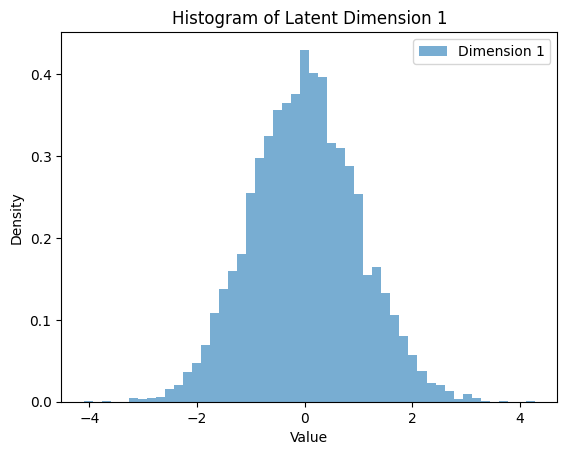

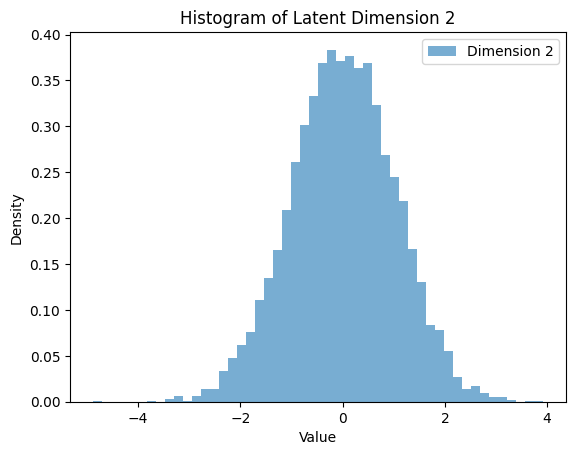

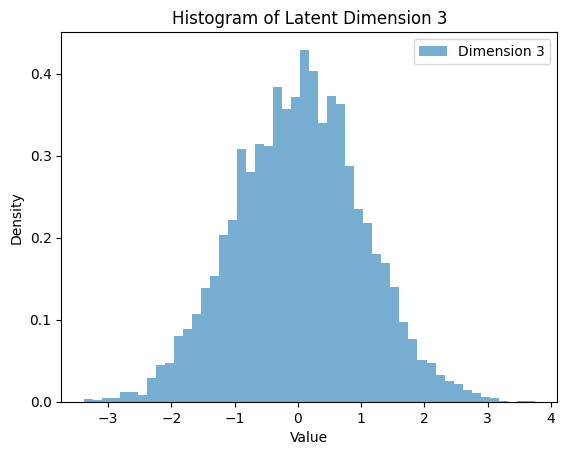

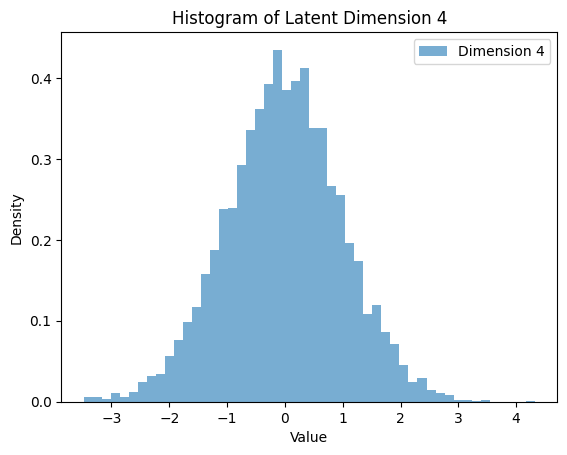

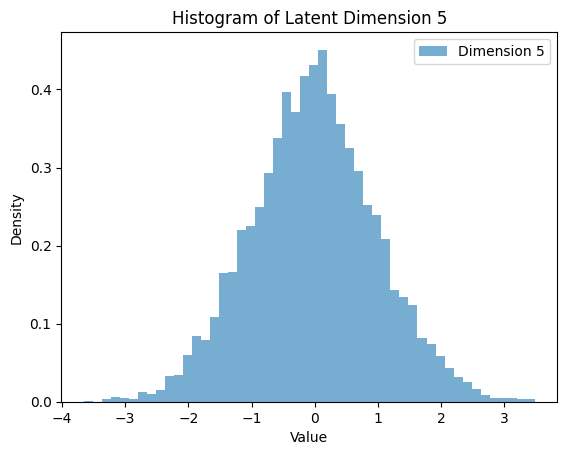

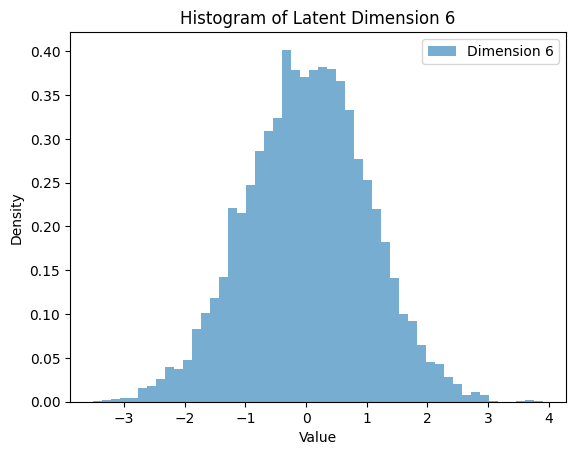

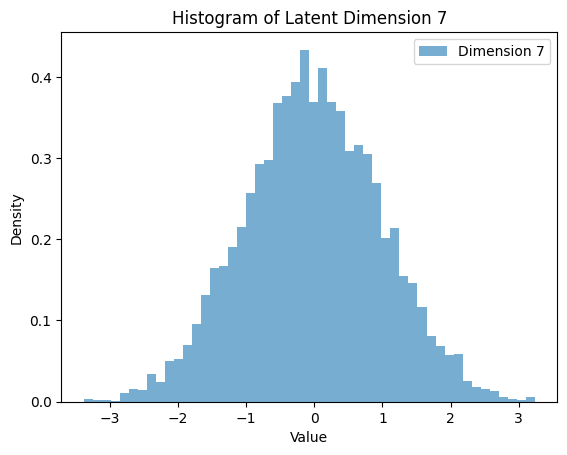

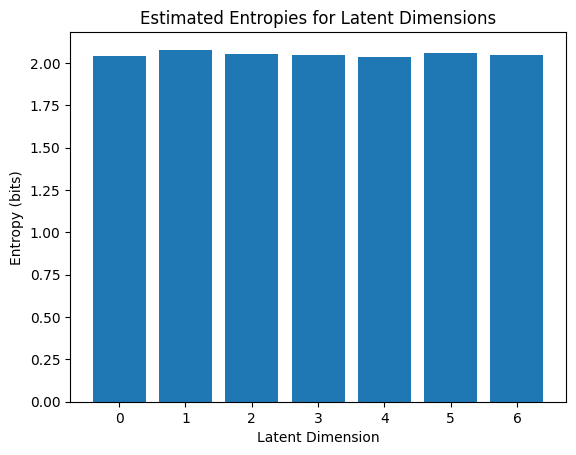

In [34]:
import matplotlib.pyplot as plt

# Plotting histograms for each dimension in the latent space
for i in range(bottleneck_dim):
    plt.hist(latent_samples[:, i], bins=50, density=True, alpha=0.6, label=f"Dimension {i+1}")
    plt.title(f"Histogram of Latent Dimension {i+1}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plotting entropies
plt.bar(range(bottleneck_dim), entropies)
plt.title("Estimated Entropies for Latent Dimensions")
plt.xlabel("Latent Dimension")
plt.ylabel("Entropy (bits)")
plt.show()


#Discuss the attributes of the reconstruction that you obtain at various SNRs and dimensionalities of the latent vector (select a range of interesting settings).

The Signal-to-Noise Ratio (SNR) and the dimensionality of the latent vector are two critical hyperparameters in a Variational Autoencoder (VAE) when noise is added to the latent space. Both can significantly influence the quality and attributes of the reconstructions. Let's discuss the potential effects of varying these parameters:

### 1. Signal-to-Noise Ratio (SNR):

The SNR is the ratio of the variance of the signal (latent variable) to the variance of the noise. A higher SNR means that the signal is much stronger than the noise, while a lower SNR means that the noise level is comparable to or even dominates the signal.

- **High SNR**:
  - **Reconstruction Quality**: Generally better, as the latent variables are less perturbed by noise.
  - **Robustness**: Might be less robust to variations in input data since the model becomes more confident about specific points in the latent space.
  - **Generalization**: Potential risk of overfitting, as the model might rely too much on precise coordinates in the latent space.

- **Low SNR**:
  - **Reconstruction Quality**: Might degrade, especially if the noise level is too high. The reconstructions might appear more "blurred" or lose specific details.
  - **Robustness**: Typically more robust, as the model learns to recover the underlying structure despite the noise.
  - **Generalization**: Better generalization, as the noise acts as a regularizer.

### 2. Dimensionality of the Latent Vector:

The dimensionality of the latent vector determines the capacity of the latent space to capture information from the input data.

- **High Dimensionality**:
  - **Reconstruction Quality**: Potentially better, as a higher-dimensional latent space can capture more nuances and details of the input data.
  - **Overfitting Risk**: Increased risk of overfitting, especially if the dataset is small. The model might memorize specific samples rather than learning the underlying data distribution.
  - **Interpretability**: Lower interpretability, as it becomes harder to visualize or understand high-dimensional spaces.

- **Low Dimensionality**:
  - **Reconstruction Quality**: Might degrade, especially if the dimensionality is too low to capture the essential features of the data.
  - **Generalization**: Typically better, as the model is forced to capture only the most salient features of the data.
  - **Interpretability**: Higher, especially for 2D or 3D latent spaces, which can be easily visualized.

### Practical Observations:

1. **Trade-off**: There's a trade-off between SNR and latent dimensionality. For instance, a higher-dimensional latent space might compensate for a lower SNR, as the model has more dimensions to capture the data's essential features.

2. **Dataset Complexity**: For complex datasets with many nuances (e.g., diverse images), a higher-dimensional latent space might be necessary. However, for simpler datasets, a low-dimensional latent space might suffice.

3. **Regularization**: If the latent dimensionality is high, consider adding other forms of regularization (e.g., dropout, weight decay) to prevent overfitting.

4. **Visualization**: Visualizing reconstructions at various SNRs and latent dimensionalities can provide insights. For instance, reconstructions at low SNRs might appear more "average" or "generic" as the noise pushes the latent variables towards more common representations.

In summary, the choice of SNR and latent dimensionality should be based on the specific dataset, task, and objectives. Experimentation, combined with validation on a held-out set, can guide the selection of these hyperparameters.